
# VSM Analiza (3D tisk prototipa) — graﬁ in interpretacije

**Podatki:** `vsm_podatki.csv` (iteracije × koraki).  
Spodaj so **kode** in **razlage** za več grafov, ki odgovarjajo na jasno zastavljena vprašanja. Vsak graf ima naslov, označeni osi in legendo, pod njim je kratek opis (2–3 stavka).


In [56]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

csv_path = "vsm_podatki_iteracije.csv"
df = pd.read_csv(csv_path)

df.columns = [c.strip() for c in df.columns]

df.head()


,Iteracija,Korak,Vloga (kdo),Trajanje (h),Cakanje (h),Tip aktivnosti (VA/NVA),Napake (st)
0,1,Priprava 3D modela implantata,Raziskovalec,0.93,0.00,VA,0
1,1,Pošiljanje modela v pregled,Raziskovalec,0.04,0.00,NVA,0
2,1,Čakanje na odobritev,Vodja laboratorija,0.00,2.70,NVA,1
3,1,Priprava tiskalnika in materiala,Raziskovalec,0.33,0.05,VA,0
4,1,Čakanje na prost tiskalnik,Raziskovalec,0.00,0.76,NVA,0



## 1) Porazdelitev časa po korakih procesa (trajanje + čakanje)

**Vprašanje:** Kateri koraki porabijo največ časa in kje se kopiči večina trajanja in čakanja?


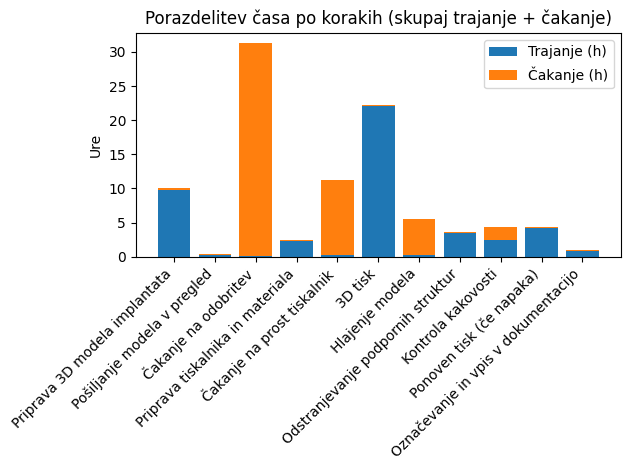

,Korak,Trajanje (h),Cakanje (h)
0,Priprava 3D modela implantata,9.80,0.23
1,Pošiljanje modela v pregled,0.30,0.16
2,Čakanje na odobritev,0.13,31.10
3,Priprava tiskalnika in materiala,2.27,0.18
4,Čakanje na prost tiskalnik,0.23,10.99
5,3D tisk,22.02,0.17
6,Hlajenje modela,0.19,5.29
7,Odstranjevanje podpornih struktur,3.45,0.25
8,Kontrola kakovosti,2.39,2.03
9,Ponoven tisk (če napaka),4.25,0.16


In [57]:
step_agg = (
    df.groupby("Korak", as_index=False, sort=False)
      .agg({
          "Trajanje (h)": "sum",
          "Cakanje (h)": "sum"
      })
)

plt.figure()
x = np.arange(len(step_agg["Korak"]))
plt.bar(x, step_agg["Trajanje (h)"], label="Trajanje (h)")
plt.bar(x, step_agg["Cakanje (h)"], bottom=step_agg["Trajanje (h)"], label="Čakanje (h)")
plt.xticks(x, step_agg["Korak"], rotation=45, ha="right")
plt.ylabel("Ure")
plt.title("Porazdelitev časa po korakih (skupaj trajanje + čakanje)")
plt.legend()
plt.tight_layout()
plt.show()

step_agg



**Interpretacija:** Vidimo, kateri koraki imajo najvišji **skupni prispevek** k času. Stolpci so sestavljeni iz dela **Trajanje** in **Čakanje**, kar omogoča hitro zaznavo korakov, kjer se kopiči neproduktivni čas. Koraki z več čakanja so kandidati za izboljšave (npr. rezervacije naprav, hitrejša odobritev).



## 2) Delež aktivnosti: VA vs NVA vs NNVA

**Vprašanje:** Kolikšen del procesa dejansko ustvarja vrednost (VA) v primerjavi z NVA in NNVA?


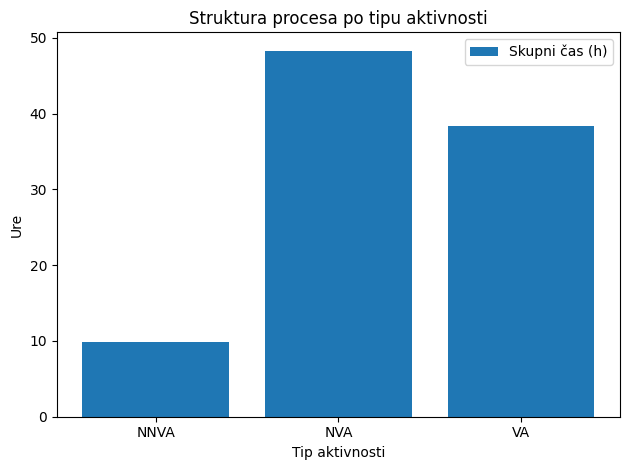

,Tip aktivnosti (VA/NVA),Skupni čas (h)
0,NNVA,9.90
1,NVA,48.33
2,VA,38.37


In [58]:

df["Skupni čas (h)"] = df["Trajanje (h)"] + df["Cakanje (h)"]
kind_agg = df.groupby("Tip aktivnosti (VA/NVA)", as_index=False)["Skupni čas (h)"].sum()

plt.figure()
plt.bar(kind_agg["Tip aktivnosti (VA/NVA)"], kind_agg["Skupni čas (h)"], label="Skupni čas (h)")
plt.xlabel("Tip aktivnosti")
plt.ylabel("Ure")
plt.title("Struktura procesa po tipu aktivnosti")
plt.legend()
plt.tight_layout()
plt.show()

kind_agg



**Interpretacija:** Stolpci prikazujejo **celotni čas** po tipih aktivnosti. **VA** predstavlja neposredno ustvarjanje vrednosti za uporabnika, **NVA** predstavlja izgube, **NNVA** pa nujne neproduktivne aktivnosti (npr. regulativa). Večji delež NVA kaže na **potencial prihrankov** z odpravo ali avtomatizacijo.



## 3) Analiza čakanja (waiting time) po korakih

**Vprašanje:** Kje v procesu se pojavljajo največji zastoji zaradi čakanja?


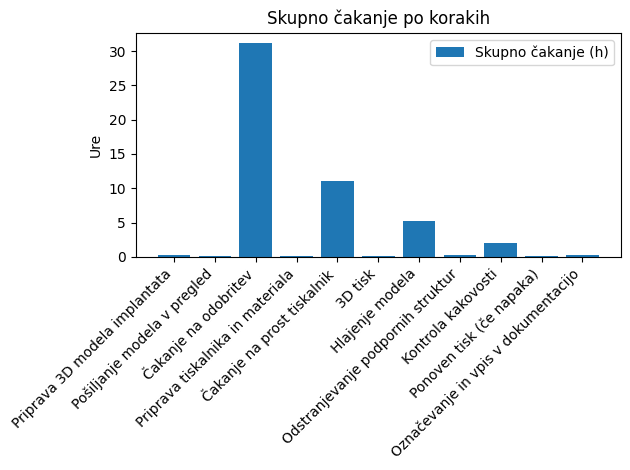

,Korak,Skupno čakanje (h),Povp. čakanje (h)
0,Priprava 3D modela implantata,0.23,0.023
1,Pošiljanje modela v pregled,0.16,0.016
2,Čakanje na odobritev,31.10,3.110
3,Priprava tiskalnika in materiala,0.18,0.018
4,Čakanje na prost tiskalnik,10.99,1.099
5,3D tisk,0.17,0.017
6,Hlajenje modela,5.29,0.529
7,Odstranjevanje podpornih struktur,0.25,0.025
8,Kontrola kakovosti,2.03,0.203
9,Ponoven tisk (če napaka),0.16,0.016


In [59]:
wait_by_step = (
    df.groupby("Korak", sort=False)
      .agg(**{
          "Skupno čakanje (h)": ("Cakanje (h)", "sum"),
          "Povp. čakanje (h)": ("Cakanje (h)", "mean"),
      })
      .reset_index()
)

plt.figure()
x = np.arange(len(wait_by_step))
plt.bar(x, wait_by_step["Skupno čakanje (h)"], label="Skupno čakanje (h)")
plt.xticks(x, wait_by_step["Korak"], rotation=45, ha="right")
plt.ylabel("Ure")
plt.title("Skupno čakanje po korakih")
plt.legend()
plt.tight_layout()
plt.show()

wait_by_step



**Interpretacija:** Koraki z največ **skupnega čakanja** povzročajo ozka grla (npr. čakanje na odobritev, prosto napravo). Ti koraki so primarni kandidati za **Kaizen** ukrepe (npr. SLA za odobritve, sistem rezervacij, paralelizacija).



## 4) Napake in ponovitve (rework)

**Vprašanje:** Pri katerih korakih se pojavlja največ napak in ali obstaja povezava med trajanjem in napakami?


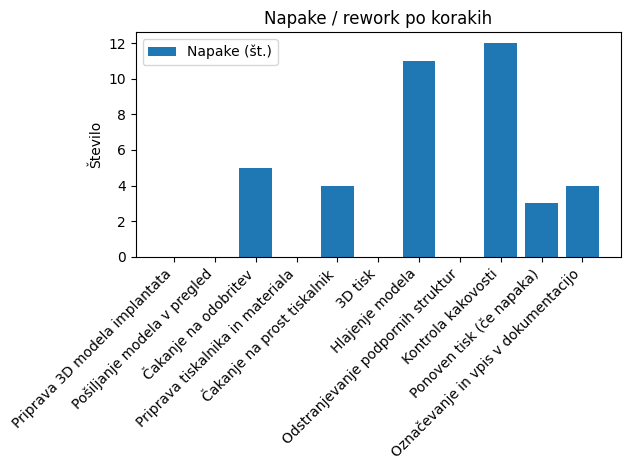

,Korak,Napake (st)
0,Priprava 3D modela implantata,0
1,Pošiljanje modela v pregled,0
2,Čakanje na odobritev,5
3,Priprava tiskalnika in materiala,0
4,Čakanje na prost tiskalnik,4
5,3D tisk,0
6,Hlajenje modela,11
7,Odstranjevanje podpornih struktur,0
8,Kontrola kakovosti,12
9,Ponoven tisk (če napaka),3


In [39]:
err_by_step = (
    df.groupby("Korak", as_index=False, sort=False)["Napake (st)"]
      .sum()
)

plt.figure()
x = np.arange(len(err_by_step["Korak"]))
plt.bar(x, err_by_step["Napake (st)"], label="Napake (št.)")
plt.xticks(x, err_by_step["Korak"], rotation=45, ha="right")
plt.ylabel("Število")
plt.title("Napake / rework po korakih")
plt.legend()
plt.tight_layout()
plt.show()

err_by_step


Najhitrejše iteracije: 8, 2
Najpočasnejše iteracije: 5, 10


,Skupina,Povp. skupni čas (h),Povp. napake (št.)
0,Najhitrejše iteracije,7.970,0.0
1,Najpočasnejše iteracije,12.235,0.5


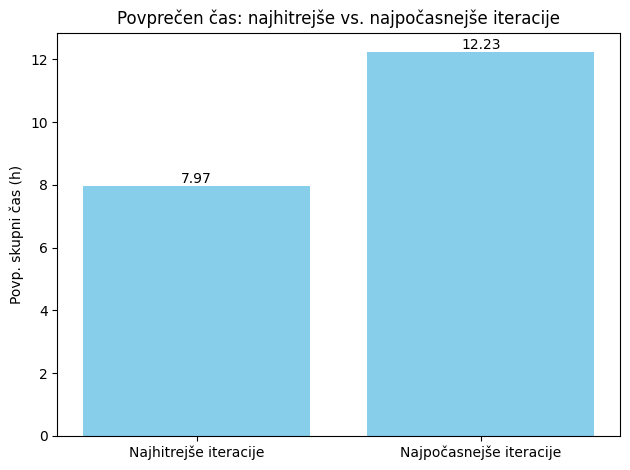

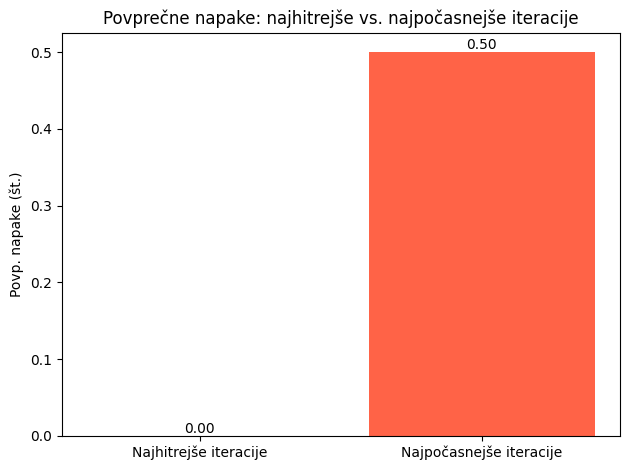

In [60]:
iter_agg = (
    df.groupby("Iteracija", sort=False)
      .agg({
          "Trajanje (h)": "sum",
          "Cakanje (h)": "sum",
          "Napake (st)": "sum"
      })
      .reset_index()
)

iter_agg["Skupni čas (h)"] = iter_agg["Trajanje (h)"] + iter_agg["Cakanje (h)"]

fastest = iter_agg.nsmallest(2, "Skupni čas (h)")
slowest = iter_agg.nlargest(2, "Skupni čas (h)")

comparison = pd.DataFrame({
    "Skupina": ["Najhitrejše iteracije", "Najpočasnejše iteracije"],
    "Povp. skupni čas (h)": [fastest["Skupni čas (h)"].mean(),
                             slowest["Skupni čas (h)"].mean()],
    "Povp. napake (št.)": [fastest["Napake (st)"].mean(),
                           slowest["Napake (st)"].mean()]
})

print("Najhitrejše iteracije:", ", ".join(fastest["Iteracija"].astype(str)))
print("Najpočasnejše iteracije:", ", ".join(slowest["Iteracija"].astype(str)))
display(comparison)

plt.figure()
x = range(len(comparison))
plt.bar(x, comparison["Povp. skupni čas (h)"], color="skyblue")
plt.xticks(x, comparison["Skupina"])
plt.ylabel("Povp. skupni čas (h)")
plt.title("Povprečen čas: najhitrejše vs. najpočasnejše iteracije")

for i, v in enumerate(comparison["Povp. skupni čas (h)"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x, comparison["Povp. napake (št.)"], color="tomato")
plt.xticks(x, comparison["Skupina"])
plt.ylabel("Povp. napake (št.)")
plt.title("Povprečne napake: najhitrejše vs. najpočasnejše iteracije")

for i, v in enumerate(comparison["Povp. napake (št.)"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

**Interpretacija**

**Graf** prikazuje, pri katerih **iteracijah** je bil skupni čas izvajanja najkrajši in najdaljši.  
Razlika med **najhitrejšimi** in **najpočasnejšimi iteracijami** nakazuje, kako se spreminja **učinkovitost celotnega procesa**.  

Prikazano je tudi **povprečno število napak** za iste skupine iteracij.  
Če imajo počasnejše iteracije več napak, to lahko pomeni, da **napake podaljšujejo skupni čas**  
(zaradi ponovitev ali dodatnih kontrol) oziroma da **kompleksnejši procesi** prinašajo več možnosti za napake.



## 5) Skupni čas procesa po iteracijah

**Vprašanje:** Kako se skupni procesni čas spreminja med ponovitvami (učenje, standardizacija, izboljšave)?


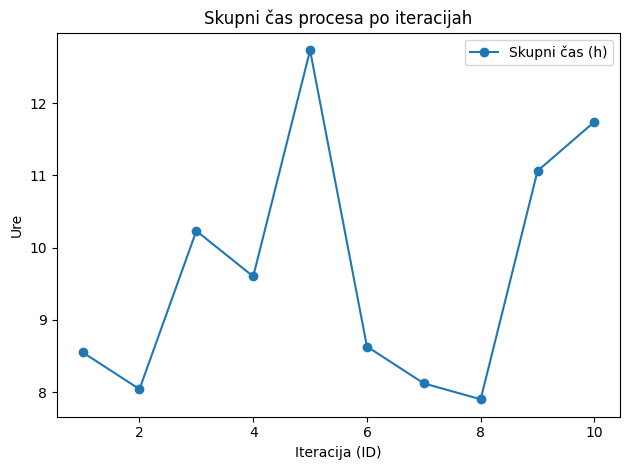

,Iteracija,Skupni čas (h)
0,1,8.55
1,2,8.04
2,3,10.23
3,4,9.60
4,5,12.73
5,6,8.63
6,7,8.12
7,8,7.90
8,9,11.06
9,10,11.74


In [61]:

iter_time = df.copy()
iter_time["Skupni čas (h)"] = iter_time["Trajanje (h)"] + iter_time["Cakanje (h)"]
iter_agg = iter_time.groupby("Iteracija", as_index=False)["Skupni čas (h)"].sum()

plt.figure()
plt.plot(iter_agg["Iteracija"], iter_agg["Skupni čas (h)"], marker="o", label="Skupni čas (h)")
plt.xlabel("Iteracija (ID)")
plt.ylabel("Ure")
plt.title("Skupni čas procesa po iteracijah")
plt.legend()
plt.tight_layout()
plt.show()

iter_agg



**Interpretacija:** Linijski prikaz pokaže, ali se **lead time** z iteracijami **znižuje** (učinek učenja/standardizacije) ali niha (nestabilnost procesa). Padajoč trend potrjuje uspeh uvedenih izboljšav.



## 6) Primerjava med vlogami (delež časa in čakanja)

**Vprašanje:** Kako so obremenitve porazdeljene med vloge (izvajanje vs. čakanje)?


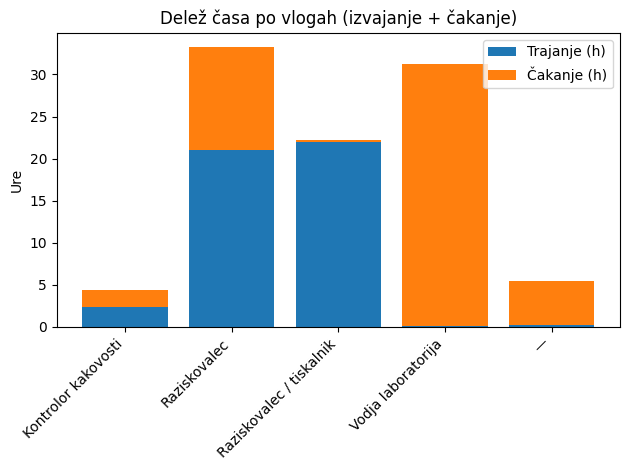

,Vloga (kdo),Trajanje (h),Cakanje (h)
0,Kontrolor kakovosti,2.39,2.03
1,Raziskovalec,21.08,12.20
2,Raziskovalec / tiskalnik,22.02,0.17
3,Vodja laboratorija,0.13,31.10
4,—,0.19,5.29


In [63]:

role_agg = df.groupby("Vloga (kdo)", as_index=False).agg({
    "Trajanje (h)": "sum",
    "Cakanje (h)": "sum"
})

plt.figure()
x = np.arange(len(role_agg["Vloga (kdo)"]))
plt.bar(x, role_agg["Trajanje (h)"], label="Trajanje (h)")
plt.bar(x, role_agg["Cakanje (h)"], bottom=role_agg["Trajanje (h)"], label="Čakanje (h)")
plt.xticks(x, role_agg["Vloga (kdo)"], rotation=45, ha="right")
plt.ylabel("Ure")
plt.title("Delež časa po vlogah (izvajanje + čakanje)")
plt.legend()
plt.tight_layout()
plt.show()

role_agg



**Interpretacija:** Stacked bar pokaže, katera vloga porabi največ **dejanskega časa** in kje se nabira **čakanje**. Neravnovesja nakazujejo možnost **re-balansiranja dela**, dodatnega usposabljanja ali avtomatizacije.



## 7) Skupna učinkovitost procesa (Lead Time = VA vs NVA/NNVA)

**Vprašanje:** Kako se celotni lead time deli na **VA** in **(N)NVA** ter kolikšen je potencialni prihranek, če NVA zmanjšamo?


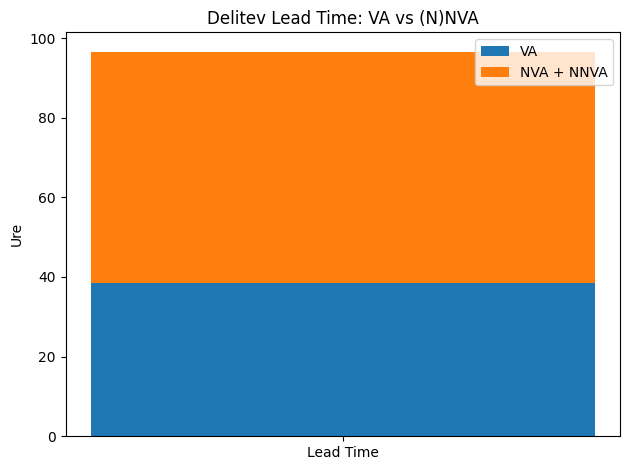

In [65]:

df["Skupni čas (h)"] = df["Trajanje (h)"] + df["Cakanje (h)"]
total_VA = df.loc[df["Tip aktivnosti (VA/NVA)"]=="VA", "Skupni čas (h)"].sum()
total_nonVA = df.loc[df["Tip aktivnosti (VA/NVA)"].isin(["NVA","NNVA"]), "Skupni čas (h)"].sum()

plt.figure()
plt.bar(["Lead Time"], [total_VA], label="VA")
plt.bar(["Lead Time"], [total_nonVA], bottom=[total_VA], label="NVA + NNVA")
plt.ylabel("Ure")
plt.title("Delitev Lead Time: VA vs (N)NVA")
plt.legend()
plt.tight_layout()
plt.show()




**Interpretacija:** Stolpec razcepi **celotni lead time** na **VA** in **(N)NVA**. Večji delež **(N)NVA** pomeni večji **potencial prihrankov** (npr. odprava administracije, zmanjšanje čakanja, avtomatizacija). Razmerje VA/(skupaj) je hiter indikator **učinkovitosti procesa**.


### C) Analiza porazdelitve in opisna statistika

Preverite porazdelitev glavnih numeričnih spremenljivk (*Trajanje_h*, *Cakanje_h*, *Napake*) z uporabo **pandas**, **matplotlib** in **scipy.stats**.  
Za vsako spremenljivko prikažite histogram in boxplot ter izvedite **Shapiro–Wilk test** za oceno normalnosti.  
Na podlagi rezultata izračunajte ustrezno opisno statistiko in pripravite tabelo z osnovnimi merami (mean ± SD ali mediana [Q1–Q3], min–max).  
Rezultate izvozite v **.csv** datoteko.


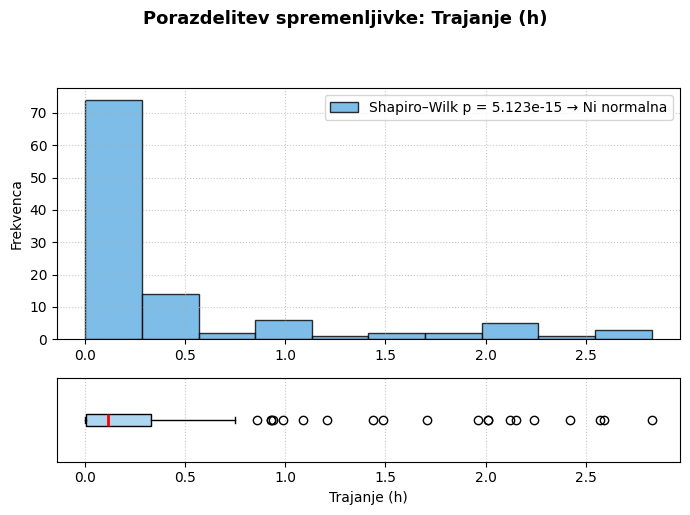

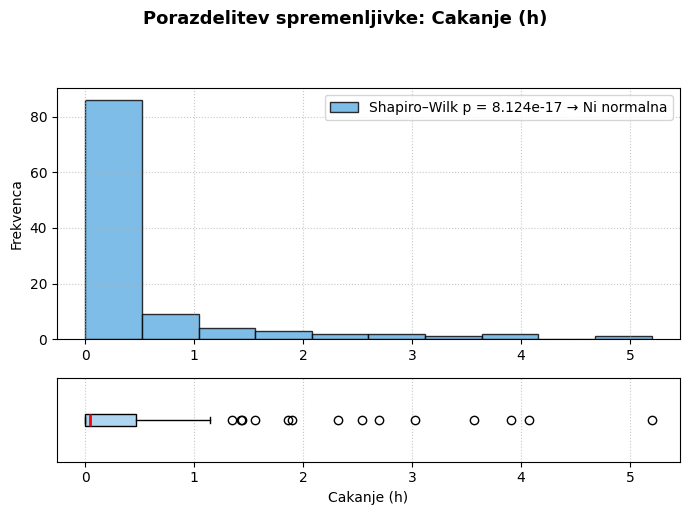

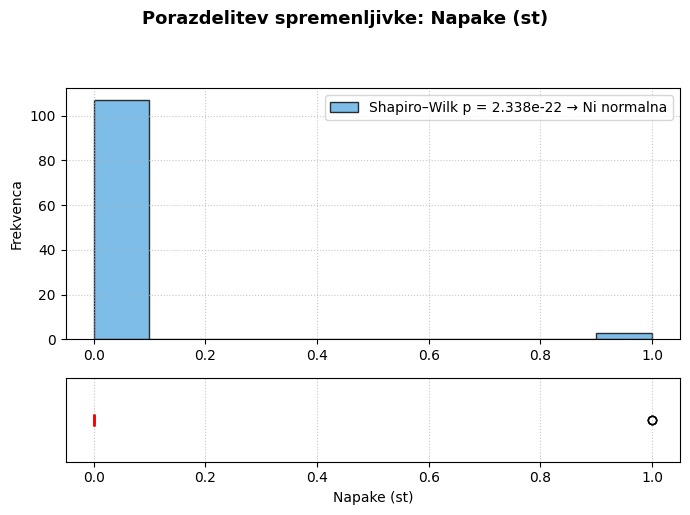

In [ ]:
plt.style.use("default")

numeric_vars = ["Trajanje (h)", "Cakanje (h)", "Napake (st)"]
results = []

for col in numeric_vars:
    data = df[col].dropna()

    stat, p = stats.shapiro(data)
    p_str = f"{p:.3e}"
    normal = p >= 0.05
    label_text = "Približno normalna" if normal else "Ni normalna"
    
    fig, axes = plt.subplots(2, 1, figsize=(7, 5), height_ratios=[3, 1])
    fig.suptitle(f"Porazdelitev spremenljivke: {col}", fontsize=13, fontweight="bold", y=1.02)

    axes[0].hist(data, bins=10, color="#5DADE2", edgecolor="black", alpha=0.8)
    axes[0].set_ylabel("Frekvenca")
    axes[0].set_xlabel("")
    axes[0].grid(True, linestyle=":", alpha=0.7)
    axes[0].legend([f"Shapiro–Wilk p = {p_str} → {label_text}"], 
                   loc="upper right", frameon=True)

    bp = axes[1].boxplot(data, vert=False, patch_artist=True,
                         boxprops=dict(facecolor="#AED6F1", color="black"),
                         medianprops=dict(color="red", linewidth=2),
                         whiskerprops=dict(color="black"),
                         capprops=dict(color="black"))
    axes[1].set_xlabel(col)
    axes[1].set_yticks([])
    axes[1].grid(True, linestyle=":", alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    if normal:
        mean = data.mean()
        std = data.std()
        desc = f"{mean:.2f} ± {std:.2f}"
    else:
        q1, q3 = data.quantile([0.25, 0.75])
        median = data.median()
        desc = f"{median:.2f} ({q1:.2f}–{q3:.2f})"

    results.append({
        "Spremenljivka": col.replace("(h)", "_h").replace("(st)", ""),
        "Opisna statistika": desc,
        "Min - Max": f"{data.min():.2f} – {data.max():.2f}",
        "Enota": "h" if "h" in col else "št.",
        "Normalnost (p)": p_str 
    })

desc_table = pd.DataFrame(results)


In [70]:
nominal_vars = ["Tip aktivnosti (VA/NVA)", "Vloga (kdo)"]

nominal_summary = []
for col in nominal_vars:
    counts = df[col].value_counts()
    total = counts.sum()
    for cat, n in counts.items():
        nominal_summary.append({
            "Spremenljivka": f"{col}: {cat}",
            "Opisna statistika": f"{n} ({(n/total*100):.1f}%)",
            "Min - Max": "",
            "Enota": ""
        })

nominal_df = pd.DataFrame(nominal_summary)

final_table = pd.concat([desc_table, nominal_df], ignore_index=True)

final_table.to_csv("opisna_tabela.csv", index=False, encoding="utf-8")
final_table


,Spremenljivka,Opisna statistika,Min - Max,Enota,Normalnost (p)
0,Trajanje _h,0.11 (0.00–0.33),0.00 – 2.83,h,5.123e-15
1,Cakanje _h,0.04 (0.00–0.46),0.00 – 5.20,h,8.124e-17
2,Napake,0.00 (0.00–0.00),0.00 – 1.00,št.,2.338e-22
3,Tip aktivnosti (VA/NVA): NVA,50 (45.5%),,,NaN
4,Tip aktivnosti (VA/NVA): VA,40 (36.4%),,,NaN
5,Tip aktivnosti (VA/NVA): NNVA,20 (18.2%),,,NaN
6,Vloga (kdo): Raziskovalec,70 (63.6%),,,NaN
7,Vloga (kdo): Vodja laboratorija,10 (9.1%),,,NaN
8,Vloga (kdo): Raziskovalec / tiskalnik,10 (9.1%),,,NaN
9,Vloga (kdo): —,10 (9.1%),,,NaN


 **Interpretacija**

Analiza pokaže, da največ časa in čakanja predstavljajo aktivnosti tipa **NVA** (ne dodajajo neposredno vrednosti), predvsem faze čakanja na odobritev in prost tiskalnik.  
Največje **izgube** se pojavljajo pri teh čakalnih korakih, kjer se proces upočasni brez dodane vrednosti za izdelek.  

Primerjava **VA** in **NVA** časa pokaže, da NVA koraki še vedno zavzemajo pomemben delež celotnega časa – zmanjšanje teh korakov bi zato imelo **največji vpliv na učinkovitost**.  

Predlagane izboljšave vključujejo **boljšo razporeditev tiskalnikov**, **avtomatizacijo odobritev** ter **hitrejši prenos podatkov** med vlogami, kar bi zmanjšalo čakalne dobe in ponovitve.
